In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])

import seaborn as sns

In [2]:
sample = pd.read_parquet('~/H_Zg/samples_processed/MC23/Zee_deriv_epairs_all_events.parquet')
new_study = False

no


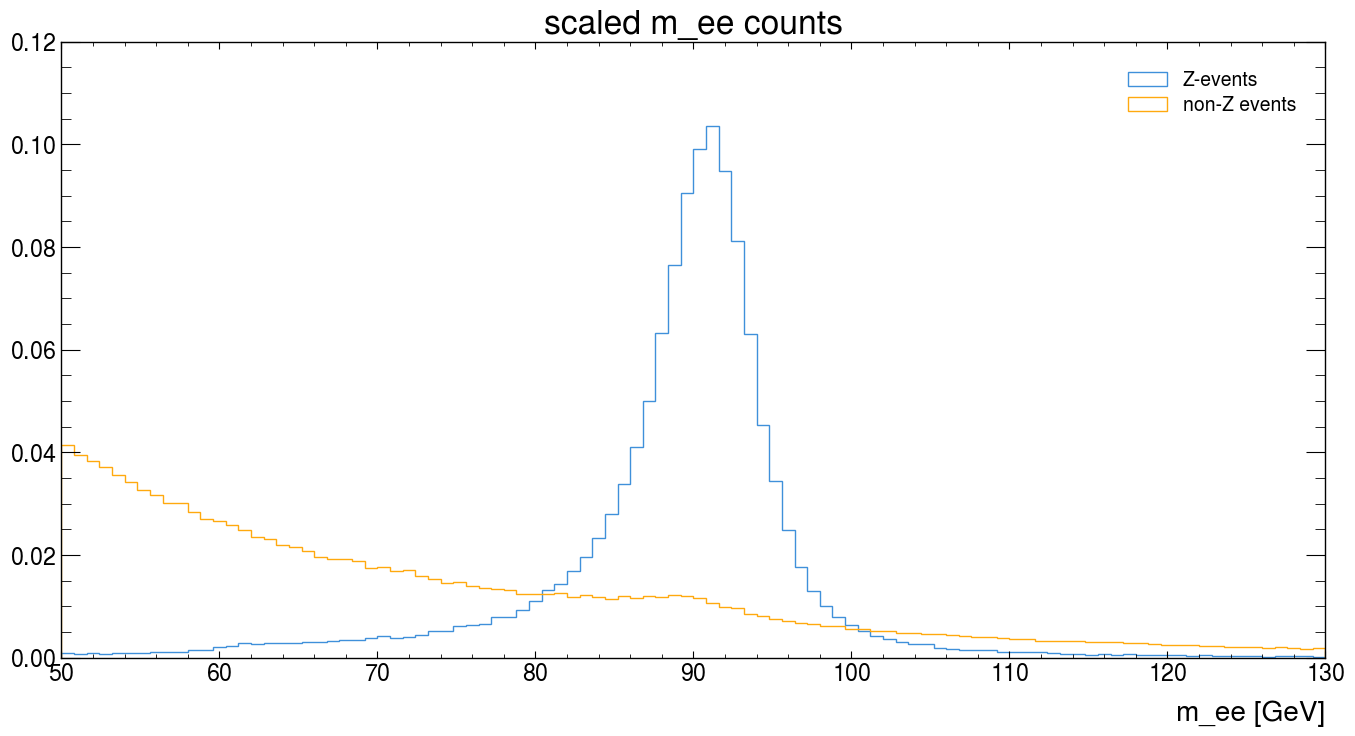

In [3]:
fig, ax = plt.subplots( figsize=(16, 8))
ax.set_title('scaled m_ee counts')
ax.hist(sample['m_ee'][sample['isZ']==1], bins=100, range=(50, 130), histtype='step', label='Z-events', density=True)
ax.hist(sample['m_ee'][sample['isZ']==0], bins=100, range=(50, 130), histtype='step', label='non-Z events', density=True)
ax.set_xlabel('m_ee [GeV]')
ax.legend()
print('no')

In [4]:
print(sample['isZ'].value_counts())

isZ
0    5139001
1     122514
Name: count, dtype: int64


In [5]:
# implement ATLAS cuts

ATLAS_Energy = (sample['el1_pt'] > 10000) & (sample['el2_pt'] > 10000)
ATLAS_Eta = (np.abs(sample['el1_eta']) < 2.47) & (np.abs(sample['el2_eta']) < 2.47)
ATLAS_Crack = (np.abs(sample['el1_eta']) > 1.37) & (np.abs(sample['el1_eta']) < 1.52) | (np.abs(sample['el2_eta']) > 1.37) & (np.abs(sample['el2_eta']) < 1.52)

ATLAS_d0sigd0 = ( (np.abs(sample['el1_GSFTrack_d0'])/np.sqrt(sample['el1_GSF_Track_Var1']) ) < 5) & \
                ( (np.abs(sample['el2_GSFTrack_d0'])/np.sqrt(sample['el2_GSF_Track_Var1']) ) < 5)

dz = np.abs(sample['el1_GSFTrack_z0'] - sample['el2_GSFTrack_z0'])
sigma_dz = np.sqrt(sample['el1_GSF_Track_Var0'] + sample['el2_GSF_Track_Var0'])

dz_sintheta1 = (dz * sample['el1_GSFTrack_theta']) < 0.5 * np.sqrt(2)
dz_sintheta2 = (dz * sample['el2_GSFTrack_theta']) < 0.5 * np.sqrt(2)

ATLAS_dz = dz_sintheta1 & dz_sintheta2

ATLAS_charge = sample['el1_charge'] != sample['el2_charge']

ATLAS_label = ATLAS_Eta & ~ATLAS_Crack & ATLAS_d0sigd0 & ATLAS_dz &\
      sample['el1_DFCommonElectrons_LHLoose'] & sample['el2_DFCommonElectrons_LHLoose'] &\
      ATLAS_charge & ATLAS_Energy



sample['ATLAS_label'] = ATLAS_label
sample['ATLAS_Energy'] = ATLAS_Energy
sample['ATLAS_charge'] = ATLAS_charge
sample['ATLAS_Eta'] = ATLAS_Eta
sample['ATLAS_Crack'] = ~ATLAS_Crack
sample['ATLAS_d0sigd0'] = ATLAS_d0sigd0
sample['ATLAS_dzsintheta'] = ATLAS_dz


In [6]:
pt1 = sample['el1_pt'][sample['isZ']==1]
pt2 = sample['el2_pt'][sample['isZ']==1]
print(f"for Z's, min pt1: {pt1.min()}, min pt2: {pt2.min()}")

for Z's, min pt1: 1425.7308349609375, min pt2: 1003.5277709960938


_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: round_numbers
axes.axisbelow: False
axes.edgecolor: black
axes.facecolor: #FFFFFF
axes.formatter.limits: [-2, 4]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: True
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: #000000
axes.labelpad: 10.0
axes.labelsize: x-large
axes.labelweight: normal
axes.linewidth: 1.0
axes.prop_cycle: cycler('color', ['#3f90da', '#ffa90e', '#bd1f01', '#94a4a2', '#832db6', '#a96b59', '#e76300', '#b9ac70', '#717581', '#92dadd'])
axes.spines.bottom: True
axes.spines.left: T

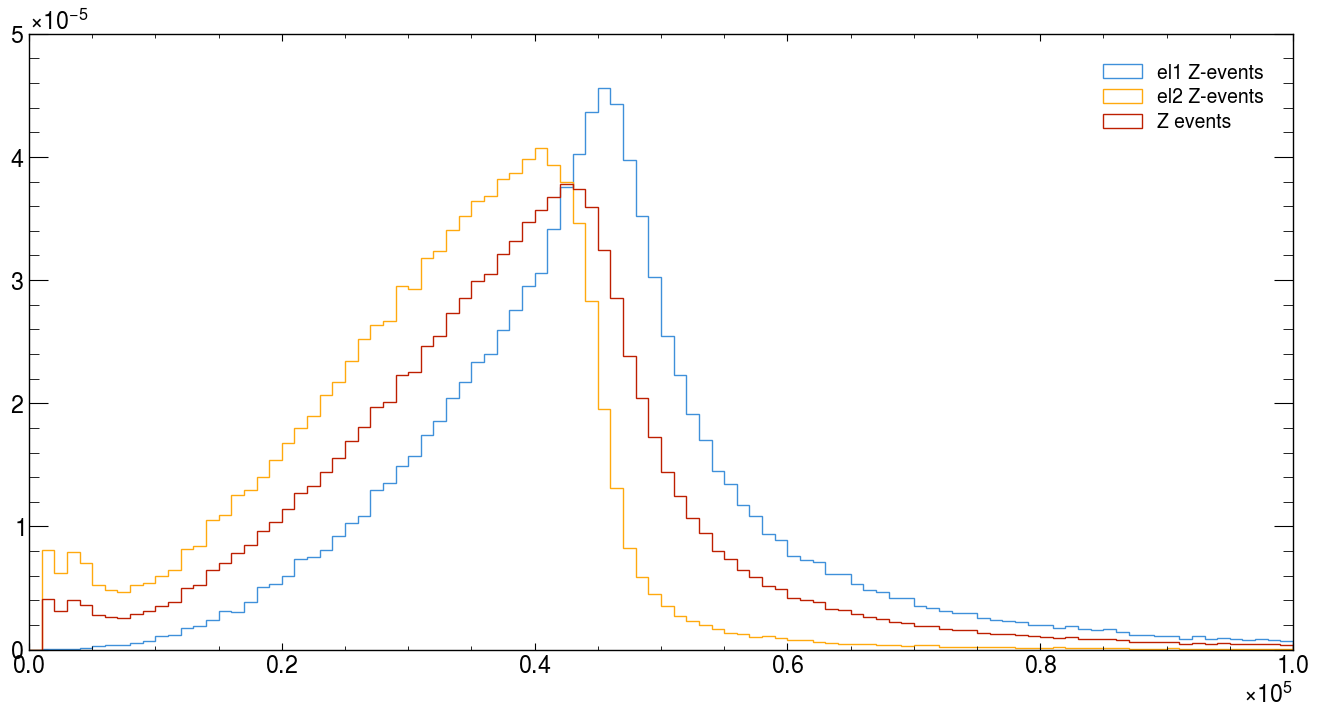

In [7]:
fig, ax = plt.subplots( figsize=(16, 8))
ax.hist(sample['el1_pt'][sample['isZ']==1], bins=100, range=(0, 100000), histtype='step', label='el1 Z-events', density=True)
ax.hist(sample['el2_pt'][sample['isZ']==1], bins=100, range=(0, 100000), histtype='step', label='el2 Z-events', density=True)

ax.hist(np.vstack((sample['el1_pt'][sample['isZ']==1], sample['el2_pt'][sample['isZ']==1])).flatten(), bins=100, range=(0, 100000), histtype='step', label='Z events', density=True)
ax.legend()
print(plt.rcParams)
old_params = plt.rcParams

In [8]:
# our mask
energy_mask = ( sample['el1_pt'] > 9000 ) & ( sample['el2_pt'] > 9000 )

print(f'our energy mask cuts {len(sample[~energy_mask])/len(sample)*100:.2f}% of pairs and {len(sample[~energy_mask & (sample['isZ']==1)])/len(sample[sample['isZ']==1])*100:.2f}% of Z pairs')

cut_sample = sample[energy_mask]
print(sample.shape)
print(cut_sample.shape)
print(cut_sample['isZ'].value_counts())

our energy mask cuts 95.95% of pairs and 4.94% of Z pairs
(5261515, 72)
(213230, 72)
isZ
1    116460
0     96770
Name: count, dtype: int64


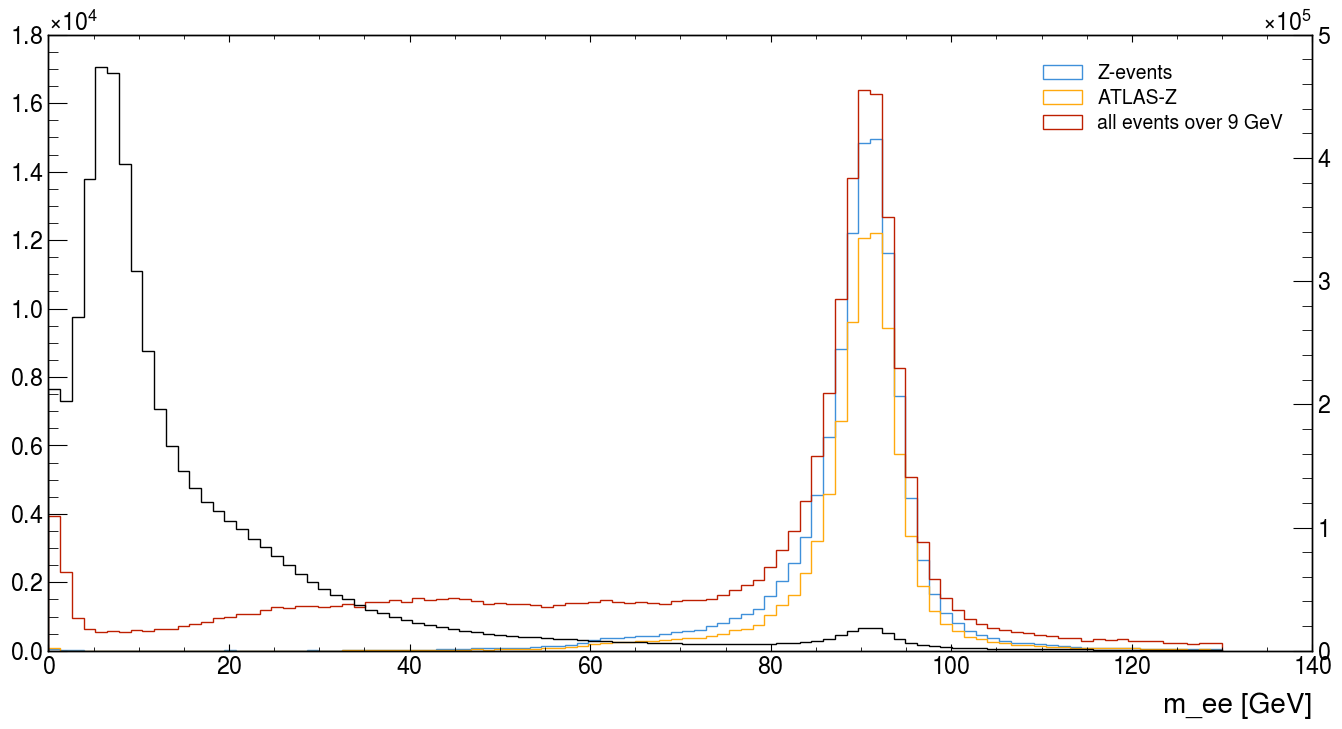

In [9]:
fig, ax = plt.subplots( figsize=(16, 8))
ax.hist(cut_sample['m_ee'][cut_sample['isZ']==1], bins=100, range=(0, 130), histtype='step', label='Z-events')
ax.hist(cut_sample['m_ee'][cut_sample['ATLAS_label']==1], bins=100, range=(0, 130), histtype='step', label='ATLAS-Z')
ax.hist(cut_sample['m_ee'], bins=100, range=(0, 130), histtype='step', label='all events over 9 GeV')
ax2 = ax.twinx()
ax2.hist(sample['m_ee'],bins=100, range=(0, 130), histtype='step',color='k', label='all events')
ax.set_xlabel('m_ee [GeV]')
ax.legend()

In [10]:
drop_list = ['isZ', 'm_ee', 'event_index', 'el1_index', 'el2_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             ,'el1_m', 'el2_m', 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFCommonElectrons_LHLoose', 'el2_DFCommonElectrons_LHLoose',
             'el1_GSFTrack_z0', 'el2_GSFTrack_z0', 'el1_GSF_Track_Var3', 'el2_GSF_Track_Var3', 'el1_GSF_dR', 'el2_GSF_dR',
             'el1_GSFTrack_d0', 'el2_GSFTrack_d0', 'ATLAS_label', 'ATLAS_Energy', 'ATLAS_Eta', 'ATLAS_Crack',
       'ATLAS_d0sigd0', 'ATLAS_dzsintheta', 'ATLAS_charge', 'el1_f1', 'el2_f1']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(cut_sample, cut_sample['isZ'], test_size=0.25, random_state=12)

In [12]:
print(X_train.drop(drop_list,axis=1).columns)



X_train = X_train.drop(drop_list, axis=1)
X_test_full = X_test
X_test = X_test.drop(drop_list, axis=1)


Index(['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'el1_eta', 'el1_charge', 'el1_ptvarcone20', 'el1_topoetcone20',
       'el1_topoetcone40', 'el1_neflowisol20', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el2_eta', 'el2_charge', 'el2_ptvarcone20', 'el2_topoetcone20',
       'el2_topoetcone40', 'el2_neflowisol20', 'el2_DFCommonElectronsECIDS',
       'el2_DFCommonElectronsECIDSResult', 'el2_DFCommonElectrons_pel'],
      dtype='object')



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: auc 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.14386144222847166
     .. Evaluation score (greater-better): auc: 0.9859175052448766
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.14579137080107596
     .. Evaluation score (greater-better): auc: 0.9852645427456342
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.1909213461527357
     .. Evaluation score (greater-better): auc: 0.9820521152764428
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.13898310521598747
 

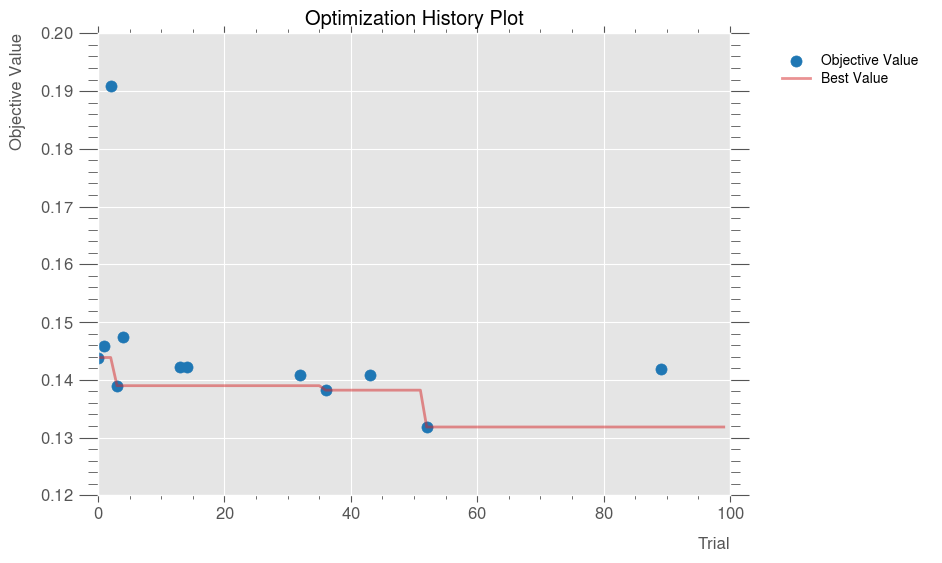

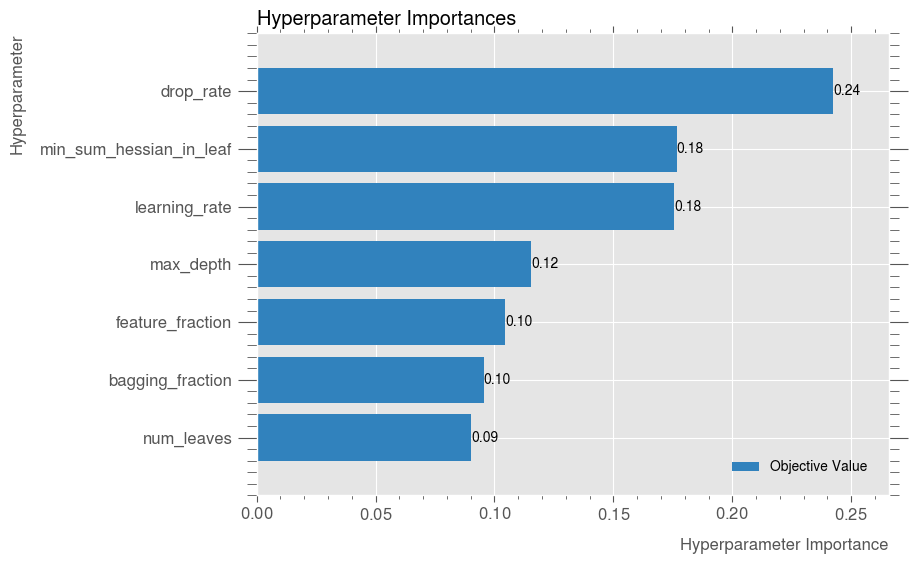

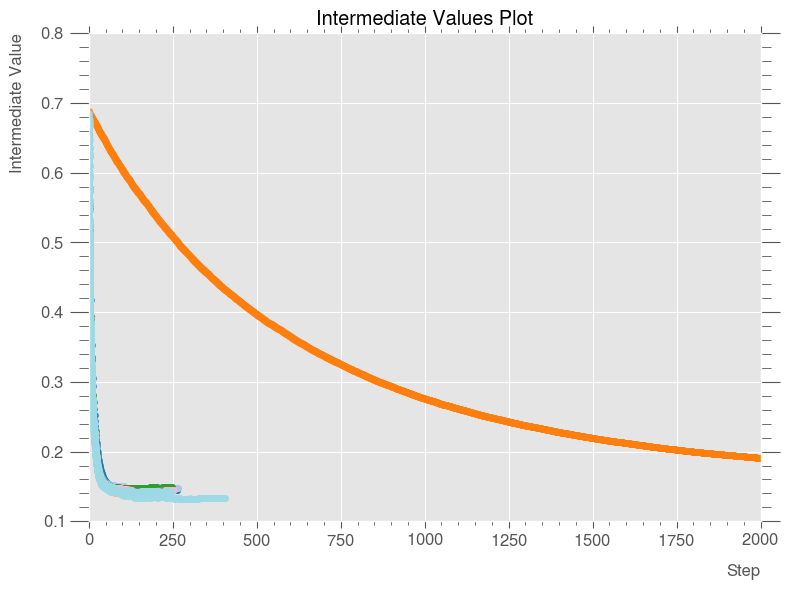

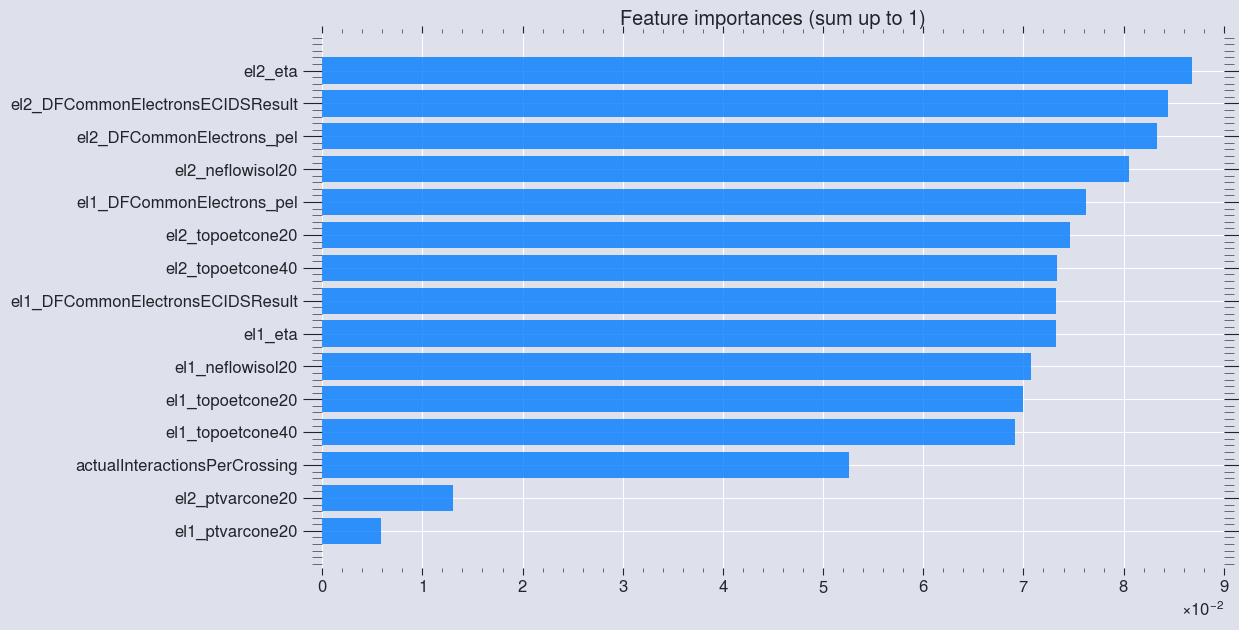


     . Optuna hyperparameters optimization finished
     .. Best trial number:52    |     log_loss:          0.13182905690763788
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 4 min 58.911 sec


In [13]:
tuner = RapidGBMTuner(metric='auc', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

In [14]:
tuner.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())


   - Fitting optimized model with the following params:
task                             : train
learning_rate                    : 0.09046459244326244
num_leaves                       : 141
feature_fraction                 : 0.8867712906473303
bagging_fraction                 : 0.5284688876789408
bagging_freq                     : 1
max_depth                        : 87
verbosity                        : -1
lambda_l1                        : 1
lambda_l2                        : 0.0
min_split_gain                   : 0.0
zero_as_missing                  : False
max_bin                          : 255
min_data_in_bin                  : 3
random_state                     : 42
device_type                      : cpu
num_classes                      : 1
objective                        : binary
metric                           : binary_logloss
num_threads                      : 38
min_sum_hessian_in_leaf          : 8.128757786516028
drop_rate                        : 0.08897465350783981
num

In [15]:
pred = tuner.predict_proba(X_test)

In [16]:
pred

array([6.36258999e-04, 1.49286775e-01, 2.55978118e-04, ...,
       3.70317406e-04, 9.89216988e-01, 1.18796871e-02])

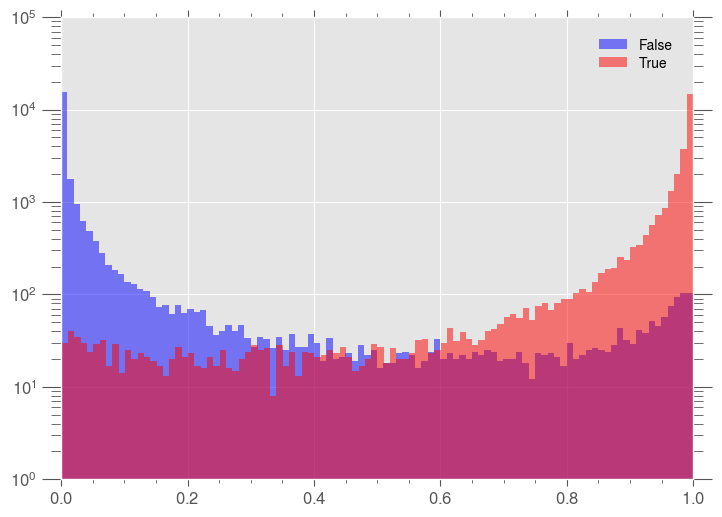

In [17]:
#plot pred histogram with color by true value
plt.hist(pred[y_test==0], bins=100, alpha=0.5, color='blue', label='False')
plt.hist(pred[y_test==1], bins=100, alpha=0.5, color='red', label='True')
plt.legend(loc='upper right')
#log scale
plt.yscale('log')


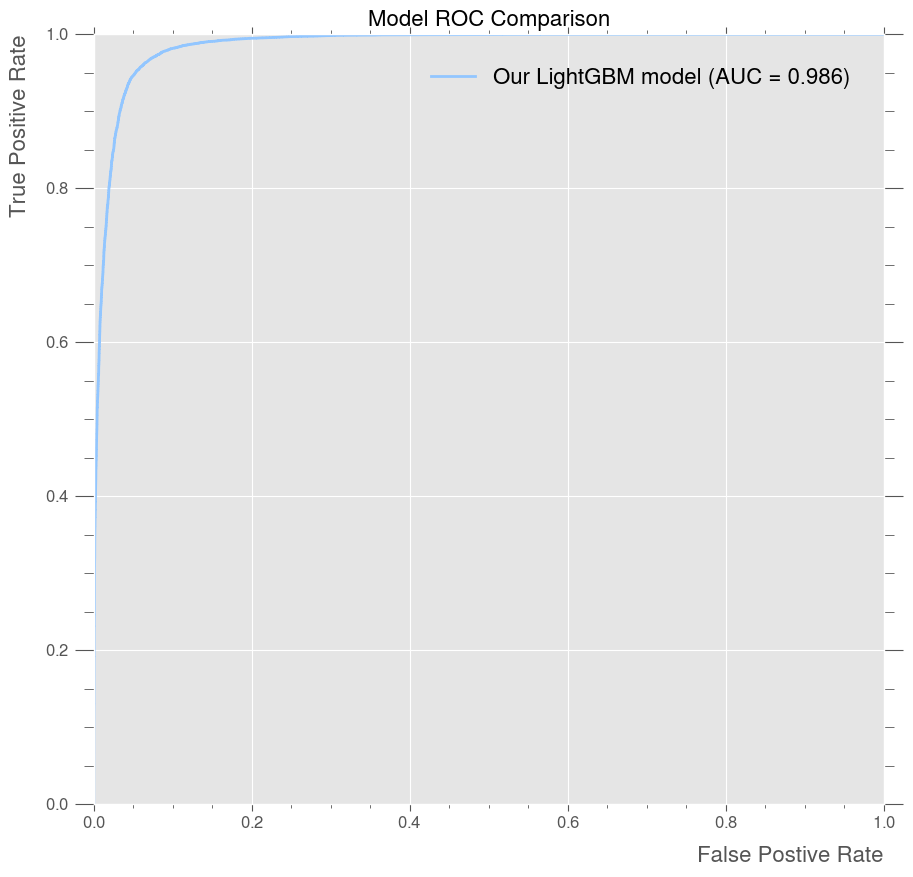

In [18]:
# Evaluate:
fpr, tpr, _ = roc_curve(y_test, pred)                  # False/True Positive Rate for our model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [19]:
print(plt.rcParams)
plt.rcParams = old_params

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: round_numbers
axes.axisbelow: True
axes.edgecolor: white
axes.facecolor: #E5E5E5
axes.formatter.limits: [-2, 4]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: True
axes.formatter.useoffset: True
axes.grid: True
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: #555555
axes.labelpad: 10.0
axes.labelsize: large
axes.labelweight: normal
axes.linewidth: 1.0
axes.prop_cycle: cycler('color', ['#92C6FF', '#97F0AA', '#FF9F9A', '#D0BBFF', '#FFFEA3', '#B0E0E6'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines.right: True
axes.spines.top: Tru

ATLAS false positives: 560
cut value: 0.9212811485708986


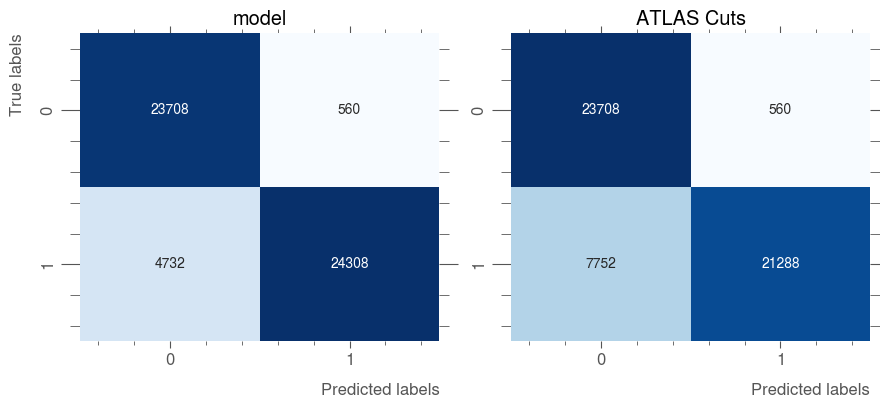

In [20]:
# confusion matrix
fp_atlas = np.sum((X_test_full['ATLAS_label']==1) & (y_test==0))
print(f'ATLAS false positives: {fp_atlas}')

cut = np.sort(pred[y_test==0])[-fp_atlas-1]
print(f'cut value: {cut}')

cm_model = confusion_matrix(y_test, pred>cut)
cm_atlas = confusion_matrix(y_test, X_test_full['ATLAS_label'])
fig, ax = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(cm_model, annot=True, fmt='d', ax=ax[0], cmap='Blues', cbar=False)
sns.heatmap(cm_atlas, annot=True, fmt='d', ax=ax[1], cmap='Blues', cbar=False)
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[1].set_xlabel('Predicted labels')
# ax[1].set_ylabel('True labels')
ax[1].set_title('ATLAS Cuts')
ax[0].set_title('model')

prediction = pred>cut

no


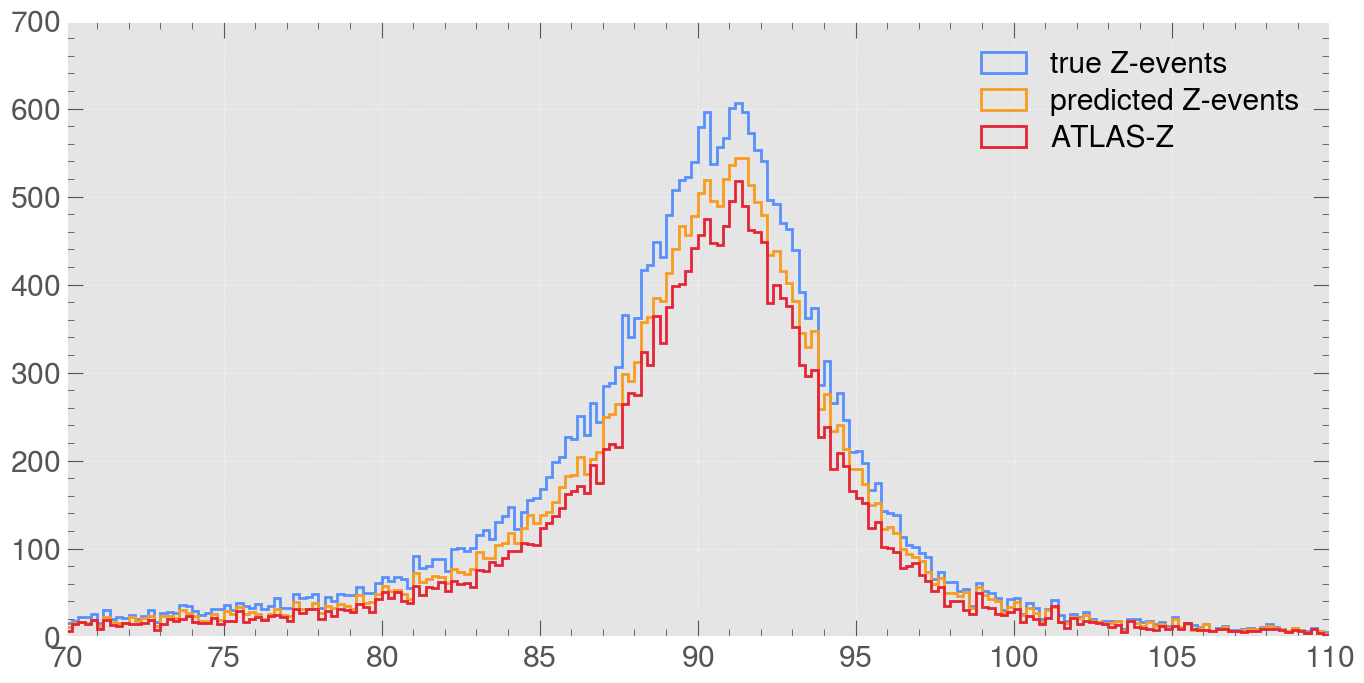

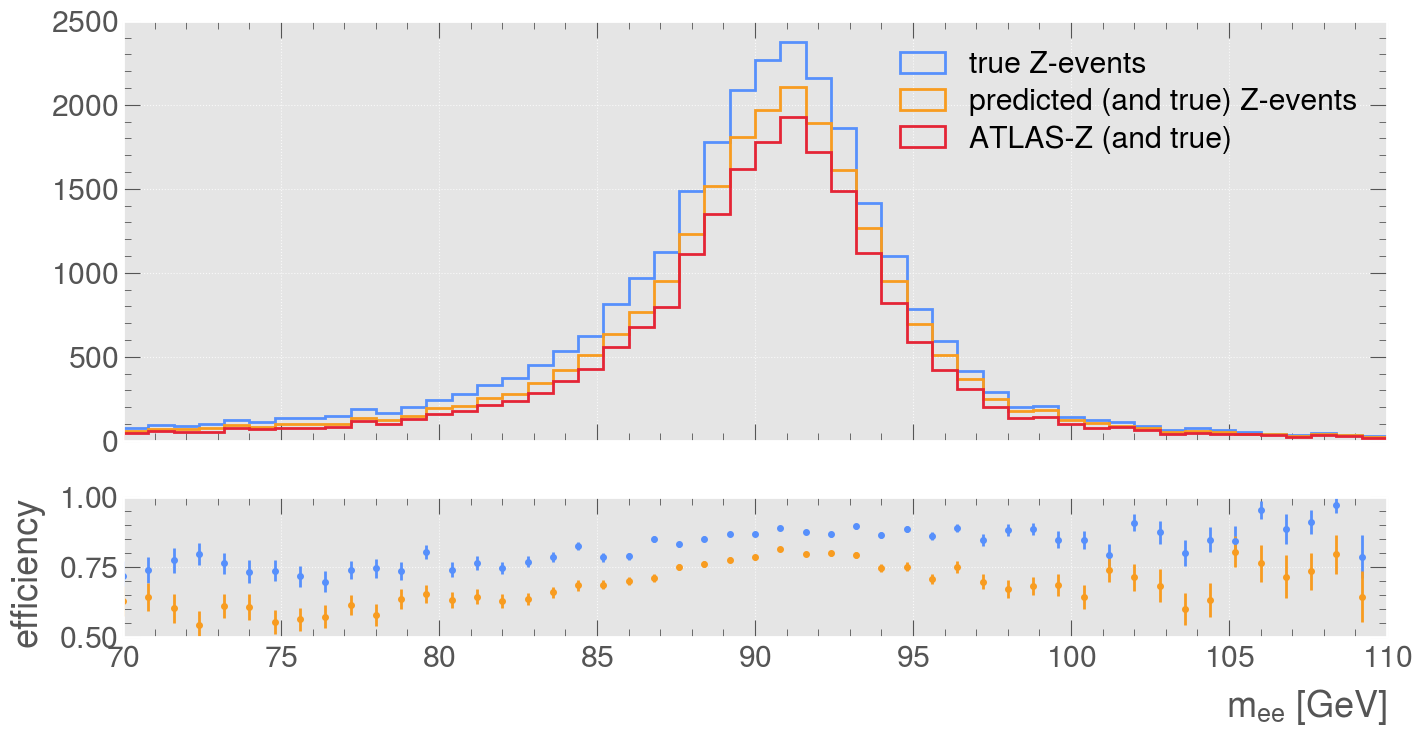

In [21]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
fig, ax = plt.subplots( figsize=(16, 8))
ax.hist(X_test_full['m_ee'][y_test==1], bins=200, range=(70, 110),linewidth=2, histtype='step', label='true Z-events')
ax.hist(X_test_full['m_ee'][prediction], bins=200, range=(70, 110),linewidth=2, histtype='step', label='predicted Z-events')
ax.hist(X_test_full['m_ee'][X_test_full['ATLAS_label']==1], bins=200,linewidth=2, range=(70, 110), histtype='step', label='ATLAS-Z')
ax.legend()

plt.style.use([hep.style.ROOT, hep.style.firamath])
fig, ax = plt.subplots(2,1, figsize=(16, 8), height_ratios=[3, 1])
counts_true, bins_true, _ = ax[0].hist(X_test_full['m_ee'][y_test==1], bins=50, range=(70, 110),linewidth=2, histtype='step', label='true Z-events')
counts_trueandmodel, bins_trueandmodel, _ = ax[0].hist(X_test_full['m_ee'][prediction & (y_test==1)], bins=50, range=(70, 110),linewidth=2, histtype='step', label='predicted (and true) Z-events')
counts_trueandATLAS, bins_TrueandATLAS, _ = ax[0].hist(X_test_full['m_ee'][(X_test_full['ATLAS_label']==1) & (y_test==1)], bins=50,linewidth=2, range=(70, 110), histtype='step', label='ATLAS-Z (and true)')
ax[0].legend()
ax[0].set_xticklabels([])
eff_model = counts_trueandmodel/counts_true
eff_ATLAS = counts_trueandATLAS/counts_true

uncertainty_model = np.sqrt(eff_model*(1-eff_model)/counts_true)
uncertainty_ATLAS = np.sqrt(eff_ATLAS*(1-eff_ATLAS)/counts_true)

ax[1].errorbar(bins_true[:-1], eff_model, yerr=uncertainty_model, fmt='.', label='model')
ax[1].errorbar(bins_true[:-1], eff_ATLAS, yerr=uncertainty_ATLAS, fmt='.', label='ATLAS')
ax[1].set_xlabel('$m_{ee}$ [GeV]')
ax[1].set_ylabel('efficiency')
ax[1].set_ylim(0.5,1)

# ax[1].legend()

print('no')

In [22]:
# save cut data with predictions, labels and ATLAS cuts
X_test_full['prediction'] = prediction
X_test_full['isZ'] = y_test
X_test_full['score'] = pred

X_test_full.to_parquet('~/H_Zg/samples_processed/MC23/Zee_deriv_epairs_all_events_cut_and_predicted.parquet')
X_test_full.drop(['prediction', 'isZ', 'score'], axis=1, inplace=True)

In [23]:
old_sample = pd.read_parquet('~/H_Zg/samples_processed/HZeeg_ggF_MC_reduced_Zmodel_eepairs_1Sep_extendedvariables80000_2labels.parquet')
old_sample = old_sample[(old_sample['el1_pt'] > 9000) & (old_sample['el2_pt'] > 9000)]

In [24]:
drop_list = ['isZ', 'isZnew', 'm_ee', 'event_index', 'el_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             , 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFcommonElectrons_LHLoose', 'el2_DFcommonElectrons_LHLoose',
             'el1_GSFTrack_z0', 'el2_GSFTrack_z0', 'el1_GSF_Track_Var3', 'el2_GSF_Track_Var3', 'el1_GSF_dR', 'el2_GSF_dR',
             'el1_GSFTrack_d0', 'el2_GSFTrack_d0', 'el1_m', 'el2_m', 'el1_f1', 'el2_f1']

In [25]:
# add ATLAS cuts:
ATLAS_Energy = (old_sample['el1_pt'] > 10000) & (old_sample['el2_pt'] > 10000)
ATLAS_Eta = (np.abs(old_sample['el1_eta']) < 2.47) & (np.abs(old_sample['el2_eta']) < 2.47)
ATLAS_Crack = (np.abs(old_sample['el1_eta']) > 1.37) & (np.abs(old_sample['el1_eta']) < 1.52) | (np.abs(old_sample['el2_eta']) > 1.37) & (np.abs(old_sample['el2_eta']) < 1.52)

ATLAS_d0sigd0 = ( (np.abs(old_sample['el1_GSFTrack_d0'])/np.sqrt(old_sample['el1_GSF_Track_Var1']) ) < 5) & \
                ( (np.abs(old_sample['el2_GSFTrack_d0'])/np.sqrt(old_sample['el2_GSF_Track_Var1']) ) < 5)

dz = np.abs(old_sample['el1_GSFTrack_z0'] - old_sample['el2_GSFTrack_z0'])

dz_sintheta1 = (dz * old_sample['el1_GSFTrack_theta']) < 0.5 * np.sqrt(2)
dz_sintheta2 = (dz * old_sample['el2_GSFTrack_theta']) < 0.5 * np.sqrt(2)

ATLAS_charge = old_sample['el1_charge'] != old_sample['el2_charge']

ATLAS_dz = dz_sintheta1 & dz_sintheta2

ATLAS_label = ATLAS_Eta & ~ATLAS_Crack & ATLAS_d0sigd0 & ATLAS_dz &\
        old_sample['el1_DFcommonElectrons_LHLoose'] & old_sample['el2_DFcommonElectrons_LHLoose'] &\
        ATLAS_charge & ATLAS_Energy


In [26]:
pred_old_sample = tuner.predict_proba(old_sample.drop(drop_list, axis=1))

old_sample['ATLAS_label'] = ATLAS_label
old_sample['ATLAS_Energy'] = ATLAS_Energy
old_sample['ATLAS_Eta'] = ATLAS_Eta
old_sample['ATLAS_Crack'] = ~ATLAS_Crack
old_sample['ATLAS_d0sigd0'] = ATLAS_d0sigd0
old_sample['ATLAS_dzsintheta'] = ATLAS_dz
old_sample['ATLAS_charge'] = ATLAS_charge

old_sample['prediction'] = pred_old_sample>cut
old_sample['score'] = pred_old_sample

old_sample.to_parquet('~/H_Zg/samples_processed/MC23/higgs_data_with_predictions.parquet')

In [28]:
ttbar_sample = pd.read_parquet('~/H_Zg/samples_processed/MC23/ttbar/ttbar_pairs_all.parquet')

In [30]:
print(ttbar_sample.columns)

Index(['event_index', 'el1_index', 'el2_index', 'runNumber', 'eventNumber',
       'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'm_ee', 'isZ', 'el1_pt', 'el1_eta', 'el1_phi', 'el1_m', 'el1_charge',
       'el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el1_DFCommonElectrons_LHLoose', 'el1_GSFTrack_d0', 'el1_GSFTrack_z0',
       'el1_GSFTrack_theta', 'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP',
       'el1_GSF_dR', 'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1',
       'el1_GSF_Track_Var2', 'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4',
       'el2_pt', 'el2_eta', 'el2_phi', 'el2_m', 'el2_charge',
       'el2_ptvarcone20', 'el2_topoetcone20', 'el2_topoetcone40', 'el2_f1',
       'el2_neflowisol20', 'el2_truthPdgId', 'el2_truthType',
       'el2_truthOr

In [31]:
ATLAS_Energy = (ttbar_sample['el1_pt'] > 10000) & (ttbar_sample['el2_pt'] > 10000)
ATLAS_Eta = (np.abs(ttbar_sample['el1_eta']) < 2.47) & (np.abs(ttbar_sample['el2_eta']) < 2.47)
ATLAS_Crack = (np.abs(ttbar_sample['el1_eta']) > 1.37) & (np.abs(ttbar_sample['el1_eta']) < 1.52) | (np.abs(ttbar_sample['el2_eta']) > 1.37) & (np.abs(ttbar_sample['el2_eta']) < 1.52)

ATLAS_d0sigd0 = ( (np.abs(ttbar_sample['el1_GSFTrack_d0'])/np.sqrt(ttbar_sample['el1_GSF_Track_Var1']) ) < 5) & \
                ( (np.abs(ttbar_sample['el2_GSFTrack_d0'])/np.sqrt(ttbar_sample['el2_GSF_Track_Var1']) ) < 5)

dz = np.abs(ttbar_sample['el1_GSFTrack_z0'] - ttbar_sample['el2_GSFTrack_z0'])

dz_sintheta1 = (dz * ttbar_sample['el1_GSFTrack_theta']) < 0.5 * np.sqrt(2)
dz_sintheta2 = (dz * ttbar_sample['el2_GSFTrack_theta']) < 0.5 * np.sqrt(2)

ATLAS_charge = ttbar_sample['el1_charge'] != ttbar_sample['el2_charge']

ATLAS_dz = dz_sintheta1 & dz_sintheta2

ATLAS_label = ATLAS_Eta & ~ATLAS_Crack & ATLAS_d0sigd0 & ATLAS_dz &\
        ttbar_sample['el1_DFCommonElectrons_LHLoose'] & ttbar_sample['el2_DFCommonElectrons_LHLoose'] &\
        ATLAS_charge & ATLAS_Energy

In [37]:
drop_list = ['el1_index', 'el2_index','isZ', 'm_ee', 'event_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             , 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFCommonElectrons_LHLoose', 'el2_DFCommonElectrons_LHLoose',
             'el1_GSFTrack_z0', 'el2_GSFTrack_z0', 'el1_GSF_Track_Var3', 'el2_GSF_Track_Var3', 'el1_GSF_dR', 'el2_GSF_dR',
             'el1_GSFTrack_d0', 'el2_GSFTrack_d0', 'el1_m', 'el2_m', 'el1_f1', 'el2_f1']

In [36]:
print(ttbar_sample.drop(drop_list, axis=1).columns)

Index(['el1_index', 'el2_index', 'actualInteractionsPerCrossing',
       'averageInteractionsPerCrossing', 'el1_eta', 'el1_charge',
       'el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40',
       'el1_neflowisol20', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el2_eta', 'el2_charge', 'el2_ptvarcone20', 'el2_topoetcone20',
       'el2_topoetcone40', 'el2_neflowisol20', 'el2_DFCommonElectronsECIDS',
       'el2_DFCommonElectronsECIDSResult', 'el2_DFCommonElectrons_pel'],
      dtype='object')


Index(['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'el1_eta', 'el1_charge', 'el1_ptvarcone20', 'el1_topoetcone20',
       'el1_topoetcone40', 'el1_neflowisol20', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el2_eta', 'el2_charge', 'el2_ptvarcone20', 'el2_topoetcone20',
       'el2_topoetcone40', 'el2_neflowisol20', 'el2_DFCommonElectronsECIDS',
       'el2_DFCommonElectronsECIDSResult', 'el2_DFCommonElectrons_pel'],
      dtype='object')

In [38]:
pred_ttbar_sample = tuner.predict_proba(ttbar_sample.drop(drop_list, axis=1))

ttbar_sample['ATLAS_label'] = ATLAS_label
ttbar_sample['ATLAS_Energy'] = ATLAS_Energy
ttbar_sample['ATLAS_Eta'] = ATLAS_Eta
ttbar_sample['ATLAS_Crack'] = ~ATLAS_Crack
ttbar_sample['ATLAS_d0sigd0'] = ATLAS_d0sigd0
ttbar_sample['ATLAS_dzsintheta'] = ATLAS_dz
ttbar_sample['ATLAS_charge'] = ATLAS_charge

ttbar_sample['prediction'] = pred_ttbar_sample>cut
ttbar_sample['score'] = pred_ttbar_sample



Text(0.5, 1.0, 'model')

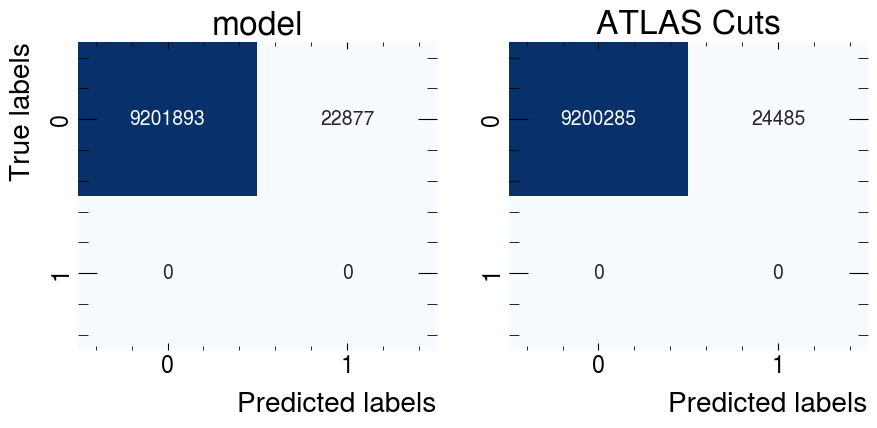

In [44]:
# confusion matrix for ATLAS and model
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(1,2,figsize=(10, 4))
cm_model = confusion_matrix(ttbar_sample['isZ'], ttbar_sample['prediction'])
cm_atlas = confusion_matrix(ttbar_sample['isZ'], ttbar_sample['ATLAS_label'])

sns.heatmap(cm_model, annot=True, fmt='d', ax=ax[0], cmap='Blues', cbar=False)
sns.heatmap(cm_atlas, annot=True, fmt='d', ax=ax[1], cmap='Blues', cbar=False)
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[1].set_xlabel('Predicted labels')
# ax[1].set_ylabel('True labels')
ax[1].set_title('ATLAS Cuts')
ax[0].set_title('model')

no


Text(1, 0, 'm_ee [GeV]')

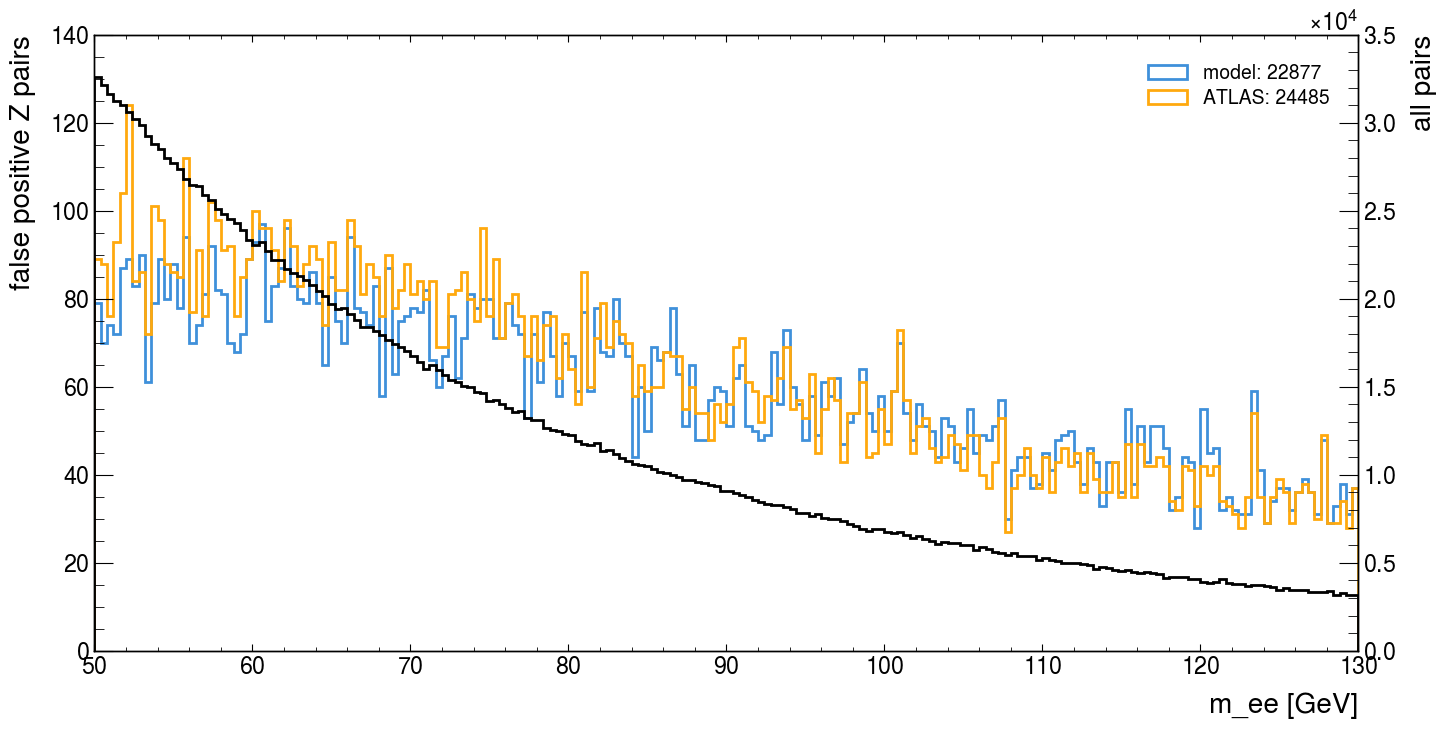

In [91]:


fig, ax = plt.subplots( figsize=(16, 8))
ax.hist(ttbar_sample['m_ee'][ttbar_sample['prediction']==1], bins=200, range=(50, 130),linewidth=2, histtype='step', label=f'model: {np.sum(ttbar_sample["prediction"]==1)}')
ax.hist(ttbar_sample['m_ee'][ttbar_sample['ATLAS_label']==1], bins=200, range=(50, 130),linewidth=2, histtype='step', label=f'ATLAS: {np.sum(ttbar_sample["ATLAS_label"]==1)}')
ax2 = ax.twinx()
ax2.hist(ttbar_sample['m_ee'],color='k', bins=200, range=(50, 130),linewidth=2, histtype='step', label='all pairs')
print('no')
ax2.set_ylabel('all pairs')
ax.set_ylabel('false positive Z pairs')
ax.legend()
ax.set_xlabel('m_ee [GeV]')

no


Text(1, 0, 'm_ee [GeV]')

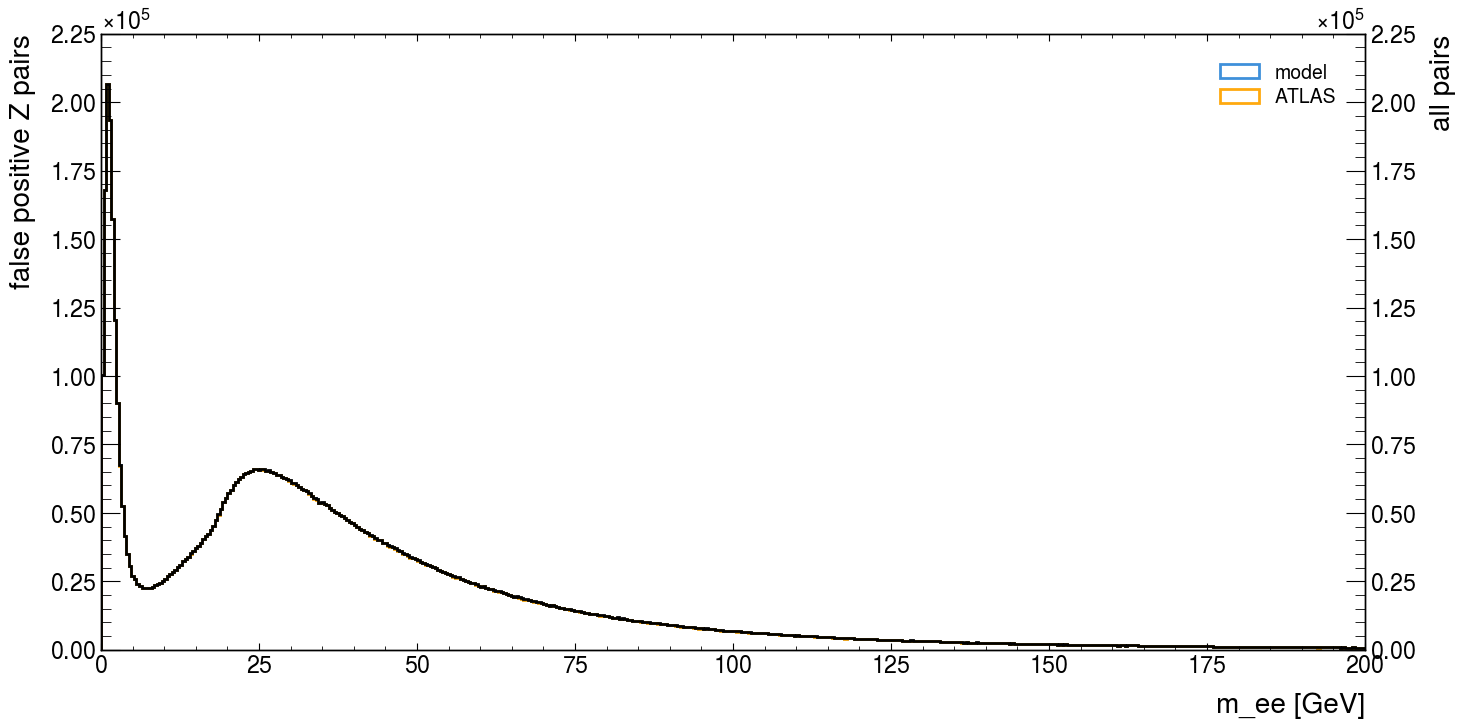

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 8))
counts_model, bins_model, _ = ax.hist(ttbar_sample['m_ee'][ttbar_sample['prediction']==0], bins=500, range=(0, 200),linewidth=2, histtype='step', label='model')
counts_atlas, bins_atlas, _ = ax.hist(ttbar_sample['m_ee'][ttbar_sample['ATLAS_label']==0], bins=500, range=(0, 200),linewidth=2, histtype='step', label='ATLAS')
ax2 = ax.twinx()
counts_all, bins_all, _ = ax2.hist(ttbar_sample['m_ee'], bins=500, range=(0, 200),color='k',linewidth=2, histtype='step', label='all pairs')
print('no')
ax2.set_ylabel('all pairs')
ax.set_ylabel('false positive Z pairs')
ax.legend()
ax.set_xlabel('m_ee [GeV]')

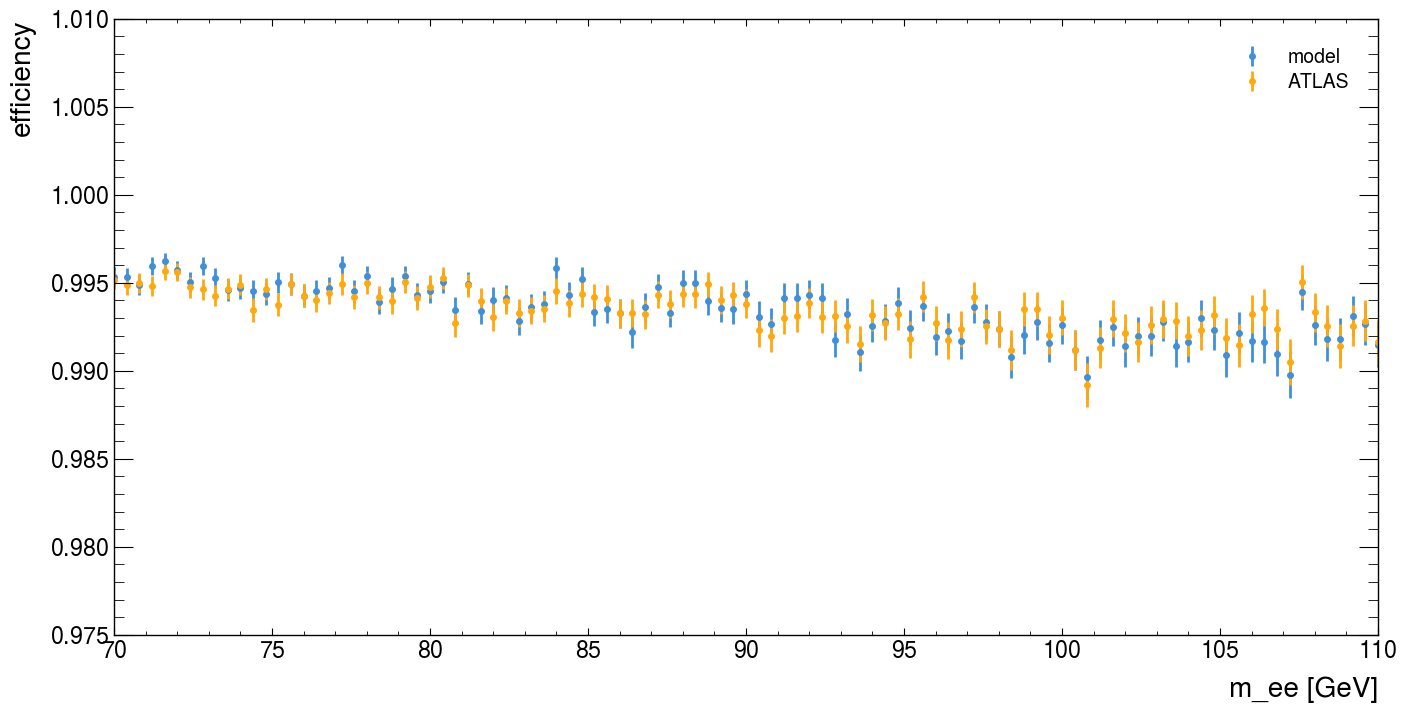

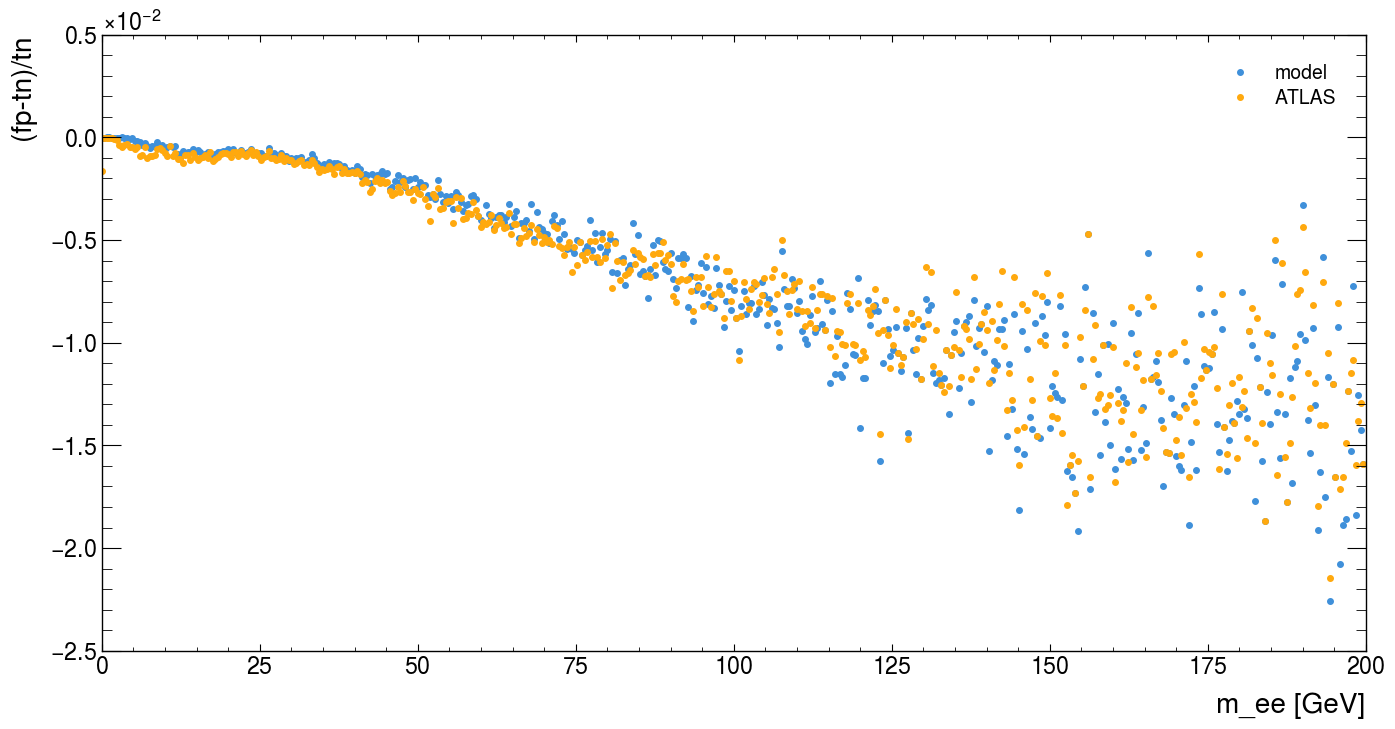

In [89]:
eff_model = counts_model/counts_all
eff_ATLAS = counts_atlas/counts_all

uncertainty_model = np.sqrt(eff_model*(1-eff_model)/counts_all)
uncertainty_ATLAS = np.sqrt(eff_ATLAS*(1-eff_ATLAS)/counts_all)

fig, ax = plt.subplots( figsize=(16, 8))
ax.errorbar(bins_model[:-1], eff_model, yerr=uncertainty_model, fmt='.', label='model')
ax.errorbar(bins_atlas[:-1], eff_ATLAS, yerr=uncertainty_ATLAS, fmt='.', label='ATLAS')
ax.set_xlabel('m_ee [GeV]')
ax.set_ylabel('efficiency')
ax.set_ylim(0.975,1.01)
ax.set_xlim(70,110)
ax.legend()

fig, ax = plt.subplots( figsize=(16, 8))
ax.plot(bins_model[:-1], (counts_model-counts_all)/counts_all,'.', label='model')
ax.plot(bins_atlas[:-1], (counts_atlas-counts_all)/counts_all,'.', label='ATLAS')
ax.set_ylabel('(fp-tn)/tn')
ax.set_xlabel('m_ee [GeV]')
ax.legend()
# ax.set_xlim(50, 130)

In [54]:
print(len(ttbar_sample))

9224770
